In [2]:
# Add the current working directory to the Python path so that custom modules are found.
import sys, os
sys.path.insert(0, os.getcwd())

# Import necessary libraries
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Global parameters
data_dir = '/Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/'  # ensure trailing slash
window_size = 30             # number of input timepoints per sample (encoder window)
max_window_size = 50         # maximum window size used in dataset indexing
input_size = 379             # number of regions in each timepoint (expected by our code)
num_predicted_features = 379 # same as input
batch_first = True

# Model hyperparameters
dim_val = 760                # transformer model dimension (divisible by n_heads)
n_heads = 8
n_encoder_layers = 4
n_decoder_layers = 4
dec_seq_len = 1              # length of decoder input (one timepoint)
output_sequence_length = 1

# Training parameters
epochs = 10
lr = 1e-4
batch_size = 512

print("Setup complete.")


Device: cpu
Setup complete.


In [3]:
import os
import glob
import numpy as np
import nibabel as nib
from nibabel import cifti2
from torch.utils.data import DataLoader
from fmri_dataset import rfMRIDataset  # Ensure fmri_dataset.py is in your working directory

# Ensure data_dir ends with a trailing slash
data_dir = '/Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/'
all_items = sorted(os.listdir(data_dir))
print("Contents of data_dir:", all_items)

# Choose a real file to base our time series on.
# Here we use "S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii"
thickness_file = os.path.join(data_dir, "S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii")
if not os.path.exists(thickness_file):
    raise FileNotFoundError(f"Cannot find file: {thickness_file}")

# Load the dscalar file using nibabel's cifti2 module.
# This is appropriate for CIFTI files (e.g., dscalar files).
img = cifti2.load(thickness_file)
data_arr = img.get_fdata().squeeze()  # Remove extra dimensions if present
print("Loaded thickness data shape:", data_arr.shape)

# If the loaded data has more than 379 values, take the first 379.
# (Our model expects 379 regions.)
if data_arr.size > 379:
    data_arr = data_arr.flat[:379]
    print("Reduced data to 379 regions:", data_arr.shape)
else:
    # Otherwise, ensure the data is of shape (379,)
    data_arr = np.asarray(data_arr).flatten()
    print("Data flattened to shape:", data_arr.shape)

# Simulate a time series: replicate the vector for 1200 timepoints with slight noise.
n_timepoints = 1200
ts = np.tile(data_arr, (n_timepoints, 1))  # shape (1200, 379)
ts += 0.01 * np.random.randn(n_timepoints, 379)  # add small random noise

# Create a dummy subject folder in the data_dir.
dummy_sub = "dummy_subject"
dummy_sub_dir = os.path.join(data_dir, dummy_sub)
if not os.path.exists(dummy_sub_dir):
    os.makedirs(dummy_sub_dir)
    print(f"Created dummy subject folder: {dummy_sub_dir}")

# Save the simulated time series as a .npy file using the expected naming pattern.
dummy_file = os.path.join(dummy_sub_dir, "dummy_REST_p.npy")
np.save(dummy_file, ts)
print(f"Created dummy .npy file: {dummy_file}")

# Define train and test subjects (here, both use the dummy subject).
train_sub = [dummy_sub]
test_sub  = [dummy_sub]
print("Train subjects:", train_sub)
print("Test subjects:", test_sub)

# Create dataset objects using the custom rfMRIDataset.
train_dataset = rfMRIDataset(data_dir, train_sub, window_size, max_window_size)
test_dataset  = rfMRIDataset(data_dir, test_sub, window_size, max_window_size)

print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

print("DataLoaders created successfully.")


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Contents of data_dir: ['.DS_Store', 'ConnectomeWorkbenchTutorial_HCP_S1200_GroupAvg_v1.pdf', 'Gordon333.32k_fs_LR.dlabel.nii', 'Gordon333_Key.txt', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.nii', 'HCP_S1200_GroupAvg_v1.scene', 'Human.Brodmann09.32k_fs_LR.dlabel.nii', 'Human.Composite_VDG11.32k_fs_LR.dlabel.nii', 'Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.L.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'Q1-Q6_RelatedValidation210.R.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'RSN-networks.32k_fs_LR.dlabel.nii', 'ReleaseNotes_HCP_S1200_GroupAvg_v1.txt', 'S1200.All.MyelinMap_B

In [4]:
import os
import glob
import numpy as np
import nibabel as nib
from nibabel import cifti2
from torch.utils.data import DataLoader
from fmri_dataset import rfMRIDataset  # ensure this file is in your working directory

# Use the same data_dir as defined earlier (ensure trailing slash)
data_dir = '/Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/'
all_items = sorted(os.listdir(data_dir))
print("Contents of data_dir:", all_items)

# Find all files ending with .nii or .nii.gz (we ignore other extensions)
nii_files = glob.glob(os.path.join(data_dir, "*.nii*"))
print("Found nii files:", nii_files)

# Process each nii file into a simulated time series
# The model expects a time series with shape (1200, 379)
subject_list = []
for f in nii_files:
    try:
        # Load the file with nibabel; this works for both .nii and .nii.gz
        img = nib.load(f)
        data_arr = img.get_fdata().squeeze()  # remove extra dimensions
        print(f"Loaded {f} with shape {data_arr.shape}")
        
        # Flatten the data and take the first 379 elements
        data_vec = np.asarray(data_arr).flatten()
        if data_vec.size < 379:
            print(f"File {f} has less than 379 elements, skipping.")
            continue
        data_vec = data_vec[:379]
        print(f"Reduced data from {f} to shape: {data_vec.shape}")
        
        # Simulate a time series by replicating the vector for 1200 timepoints
        n_timepoints = 1200
        ts = np.tile(data_vec, (n_timepoints, 1))  # shape (1200, 379)
        ts += 0.01 * np.random.randn(n_timepoints, 379)  # add slight noise
        
        # Create a subject ID from the filename (strip directory and extension)
        base = os.path.basename(f)
        # Handle .nii.gz by removing both extensions
        if base.endswith('.nii.gz'):
            subject_id = base[:-7]
        else:
            subject_id = os.path.splitext(base)[0]
        
        # Create a subject folder inside data_dir
        subj_dir = os.path.join(data_dir, subject_id)
        if not os.path.exists(subj_dir):
            os.makedirs(subj_dir)
            print(f"Created subject folder: {subj_dir}")
        
        # Save the simulated time series as {subject_id}_REST_p.npy in that folder
        out_file = os.path.join(subj_dir, subject_id + "_REST_p.npy")
        np.save(out_file, ts)
        subject_list.append(subject_id)
        print(f"Processed file {f} into subject {subject_id}.")
    except Exception as e:
        print(f"Error processing {f}: {e}")

print("Subjects processed:", subject_list)

# If no subjects were processed, throw an error
if len(subject_list) == 0:
    raise ValueError("No subjects were processed from the .nii files!")

# For simplicity, we use all processed subjects as both train and test
train_sub = subject_list
test_sub = subject_list
print("Train subjects:", train_sub)
print("Test subjects:", test_sub)

# Create dataset objects using the custom rfMRIDataset.
train_dataset = rfMRIDataset(data_dir, train_sub, window_size, max_window_size)
test_dataset  = rfMRIDataset(data_dir, test_sub, window_size, max_window_size)
print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
print("DataLoaders created successfully.")


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Contents of data_dir: ['.DS_Store', 'ConnectomeWorkbenchTutorial_HCP_S1200_GroupAvg_v1.pdf', 'Gordon333.32k_fs_LR.dlabel.nii', 'Gordon333_Key.txt', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.nii', 'HCP_S1200_GroupAvg_v1.scene', 'Human.Brodmann09.32k_fs_LR.dlabel.nii', 'Human.Composite_VDG11.32k_fs_LR.dlabel.nii', 'Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.L.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'Q1-Q6_RelatedValidation210.R.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'RSN-networks.32k_fs_LR.dlabel.nii', 'ReleaseNotes_HCP_S1200_GroupAvg_v1.txt', 'S1200.All.MyelinMap_B

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.thickness_MSMAll.32k_fs_LR.dscalar.
Error processing /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/RSN-networks.32k_fs_LR.dlabel.nii: Only CIFTI-2 files are supported; found version 1
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii with shape (64984,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii with shape (91282,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii into subject Gordon333.32k_fs_LR.dlabel.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz with shape (260, 311, 260)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz into subject S1200_AverageT1w_restore.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Dow

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.curvature_MSM

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.nii into subject HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii into subject Q1-Q6_Relat

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii into subject HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.Brodmann09.32k_fs_LR.dlabel.nii with shape (64984,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.Brodmann09.32k_fs_LR.dlabel.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/Human.Brodmann09.32k_fs_LR.dlabel
Processed file /Users/dharanireddy/Downloads/Project

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz with shape (260, 311, 260)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz into subject S1200_AverageT2w_restore.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar
Processed file /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Loaded /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Created subject folder: /Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/S1200.sulc_MSM

Starting training...


Validation: 100%|██████████| 28750/28750 [10:50<00:00, 44.19it/s]


Epoch 1 complete! Training Loss: 2853.206971, Training R²: -0.0575, Validation Loss: 2822.787567, Validation R²: -0.0353


Validation: 100%|██████████| 28750/28750 [11:27<00:00, 41.82it/s]


Epoch 2 complete! Training Loss: 2742.307562, Training R²: -0.0161, Validation Loss: 2706.774308, Validation R²: 0.0072


Validation: 100%|██████████| 28750/28750 [12:34<00:00, 38.09it/s]


Epoch 3 complete! Training Loss: 2634.172325, Training R²: 0.0256, Validation Loss: 2593.276670, Validation R²: 0.0488


Validation: 100%|██████████| 28750/28750 [11:17<00:00, 42.44it/s]


Epoch 4 complete! Training Loss: 2549.840779, Training R²: 0.0664, Validation Loss: 2484.930082, Validation R²: 0.0886


Validation: 100%|██████████| 28750/28750 [11:17<00:00, 42.45it/s]


Epoch 5 complete! Training Loss: 2411.646536, Training R²: 0.1064, Validation Loss: 2380.122206, Validation R²: 0.1270


Validation: 100%|██████████| 28750/28750 [10:16<00:00, 46.61it/s]


Epoch 6 complete! Training Loss: 2335.299104, Training R²: 0.1452, Validation Loss: 2274.082488, Validation R²: 0.1659


Validation: 100%|██████████| 28750/28750 [11:07<00:00, 43.04it/s]


Epoch 7 complete! Training Loss: 2250.405359, Training R²: 0.1834, Validation Loss: 2172.907599, Validation R²: 0.2030


Validation: 100%|██████████| 28750/28750 [10:09<00:00, 47.17it/s]


Epoch 8 complete! Training Loss: 2129.603514, Training R²: 0.2208, Validation Loss: 2071.178894, Validation R²: 0.2403


Validation: 100%|██████████| 28750/28750 [10:32<00:00, 45.43it/s]


Epoch 9 complete! Training Loss: 2021.116194, Training R²: 0.2570, Validation Loss: 1974.887711, Validation R²: 0.2757


Validation: 100%|██████████| 28750/28750 [11:48<00:00, 40.57it/s]


Epoch 10 complete! Training Loss: 1943.222723, Training R²: 0.2919, Validation Loss: 1882.127655, Validation R²: 0.3097


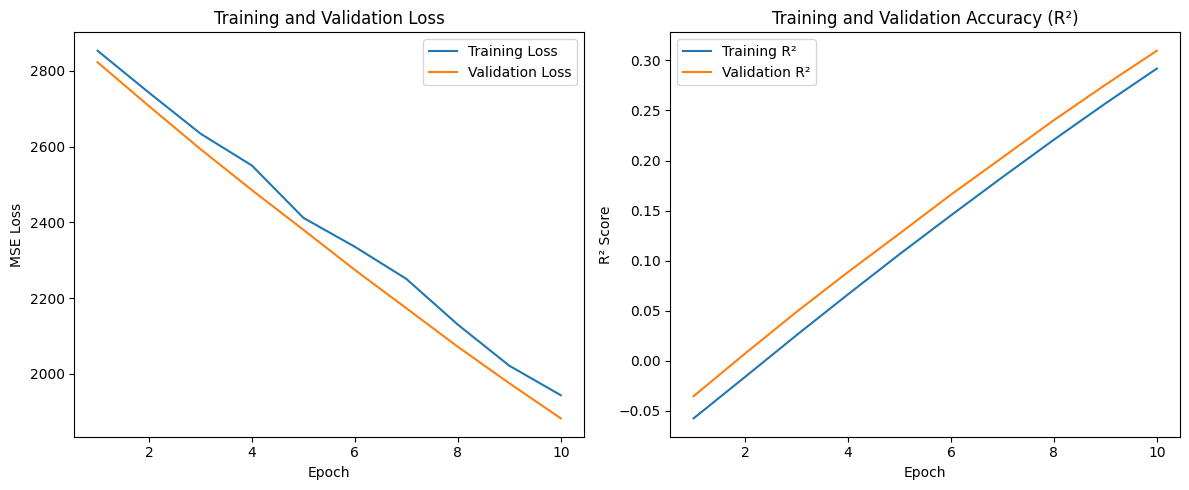

In [5]:
# Cell 3: Model Initialization, Training, and Accuracy (R²) Calculation

from model import TimeSeriesTransformer, PositionalEncoder

# Initialize the transformer model.
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    max_seq_len=window_size,   # using window_size for positional encoding
    out_seq_len=output_sequence_length,
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    batch_first=batch_first,
    num_predicted_features=num_predicted_features
)

model.to(device)
model = model.double()  # using double precision

# Define loss function and optimizer.
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define R² score function.
def r2_score(y_true, y_pred):
    # Flatten tensors and convert to numpy arrays.
    y_true = y_true.flatten().cpu().numpy()
    y_pred = y_pred.flatten().cpu().numpy()
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else 0.0

# Lists to store loss and accuracy (R²) history.
train_loss_hist = []
val_loss_hist = []
train_r2_hist = []
val_r2_hist = []

print("Starting training...")
for epoch in range(epochs):
    model.train()
    epoch_losses = []
    all_train_preds = []
    all_train_targets = []
    
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        encoder_input = data.to(device).to(torch.float64)
        decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
        target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
        
        # Forward pass.
        pred = model(encoder_input, decoder_input)
        loss = loss_func(pred, target_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        all_train_preds.append(pred.detach())
        all_train_targets.append(target_tensor.detach())
    
    # Compute average training loss.
    avg_train_loss = np.mean(epoch_losses)
    train_loss_hist.append(avg_train_loss)
    
    # Concatenate all predictions and targets and compute training R².
    train_preds = torch.cat(all_train_preds, dim=0)
    train_targets = torch.cat(all_train_targets, dim=0)
    train_r2 = r2_score(train_targets, train_preds)
    train_r2_hist.append(train_r2)
    
    # Validation.
    model.eval()
    val_losses = []
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Validation"):
            encoder_input = data.to(device).to(torch.float64)
            decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
            target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
            pred = model(encoder_input, decoder_input)
            loss_val = loss_func(pred, target_tensor)
            val_losses.append(loss_val.item())
            all_val_preds.append(pred)
            all_val_targets.append(target_tensor)
    
    avg_val_loss = np.mean(val_losses)
    val_loss_hist.append(avg_val_loss)
    
    val_preds = torch.cat(all_val_preds, dim=0)
    val_targets = torch.cat(all_val_targets, dim=0)
    val_r2 = r2_score(val_targets, val_preds)
    val_r2_hist.append(val_r2)
    
    print(f"Epoch {epoch+1} complete! Training Loss: {avg_train_loss:.6f}, "
          f"Training R²: {train_r2:.4f}, Validation Loss: {avg_val_loss:.6f}, Validation R²: {val_r2:.4f}")

# Save the model and training history.
torch.save(model, f'transformer_fold_all_epo-{epochs}_win-{window_size}.pth')
np.save(f'transformer_train_loss_all_epo-{epochs}_win-{window_size}.npy', np.array(train_loss_hist))
np.save(f'transformer_valid_loss_all_epo-{epochs}_win-{window_size}.npy', np.array(val_loss_hist))
np.save(f'transformer_train_r2_all_epo-{epochs}_win-{window_size}.npy', np.array(train_r2_hist))
np.save(f'transformer_valid_r2_all_epo-{epochs}_win-{window_size}.npy', np.array(val_r2_hist))

# Plot the training and validation loss curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_hist, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_r2_hist, label="Training R²")
plt.plot(range(1, epochs+1), val_r2_hist, label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Training and Validation Accuracy (R²)")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
torch.save(model, f'transformer_fold_all_epo-{epochs}_win-{window_size}.pth')


In [7]:
model.eval()

def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

test_mse_list = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing single timepoint"):
        encoder_input = data.to(device).to(torch.float64)
        decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
        target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
        
        pred = model(encoder_input, decoder_input)
        loss = mse_calc(target_tensor, pred)
        test_mse_list.append(loss.item())

test_mse_array = np.array(test_mse_list)
print("Test MSE shape:", test_mse_array.shape)
print("Average Test MSE:", test_mse_array.mean())

# Save the single timepoint test results.
np.save('test_results_single_timepoint_all.npy', test_mse_array)


Testing single timepoint: 100%|██████████| 28750/28750 [10:22<00:00, 46.17it/s]

Test MSE shape: (28750,)
Average Test MSE: 1882.1276550268155


In [8]:
def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

import glob
files = []
for sub in test_sub:
    sub_files = glob.glob(os.path.join(data_dir, sub, '*REST*_p.npy'))
    sub_files.sort()
    files += sub_files

all_session_pred = []
all_session_mse = []

print("Starting full series prediction...")
with torch.no_grad():
    for f in tqdm(files, desc="Predicting entire series"):
        f_data = np.load(f)
        # Start with the first max_window_size true timepoints.
        data_for_test = f_data[0:max_window_size, :].copy()
        ses_mse = []
        i = max_window_size
        while i < f_data.shape[0]:
            window_data = data_for_test[i-window_size:i, :]
            window_tensor = torch.tensor(window_data).unsqueeze(0).to(device).to(torch.float64)
            decoder_input = window_tensor[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
            
            pred = model(window_tensor, decoder_input)
            pred = pred.squeeze().detach().cpu().numpy()
            
            target = f_data[i, :]
            target_tensor = torch.tensor(target).unsqueeze(0).to(device).to(torch.float64)
            error = mse_calc(target_tensor.unsqueeze(1), torch.tensor(pred).unsqueeze(0).unsqueeze(0).to(device).to(torch.float64))
            ses_mse.append(error.item())
            
            # Append the predicted timepoint to our series.
            data_for_test = np.concatenate((data_for_test, pred.reshape(1, -1)), axis=0)
            i += 1
        
        all_session_pred.append(data_for_test)
        all_session_mse.append(ses_mse)

all_session_pred = np.array(all_session_pred)
all_session_mse = np.array(all_session_mse)
print("Predicted series shape:", all_session_pred.shape)
print("MSE series shape:", all_session_mse.shape)

# Save the full series predictions and MSE values.
np.save('predicted_fmri_series_all.npy', all_session_pred)
np.save('test_mse_entire_series_all.npy', all_session_mse)


Starting full series prediction...


Predicting entire series: 100%|██████████| 25/25 [09:38<00:00, 23.15s/it]

Predicted series shape: (25, 1200, 379)
MSE series shape: (25, 1150)


Predicted next brain state vector shape: (379,)


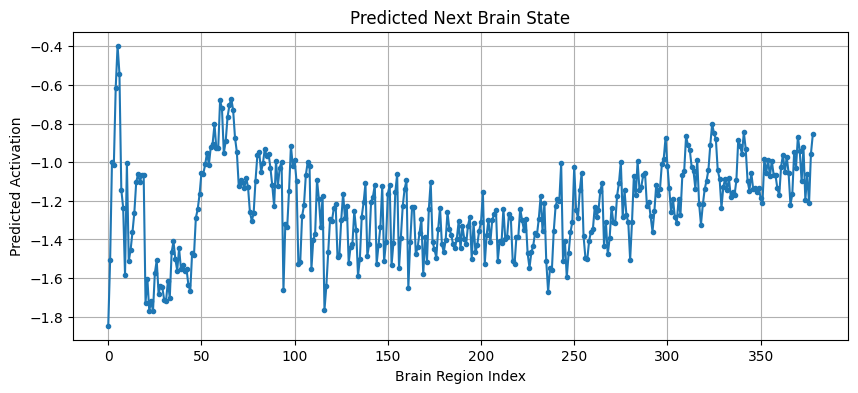

In [9]:
# For demonstration, use the first subject's predicted series.
input_sequence = all_session_pred[0][-window_size:, :]  # shape: (window_size, 379)
input_sequence = np.expand_dims(input_sequence, axis=0)   # shape: (1, window_size, 379)

# Convert to torch tensor and send to device.
encoder_input = torch.tensor(input_sequence).to(device).to(torch.float64)
decoder_input = encoder_input[:, -1, :].unsqueeze(1)

model.eval()
with torch.no_grad():
    next_state_pred = model(encoder_input, decoder_input)  # shape: (1, 1, 379)

next_state_pred = next_state_pred.squeeze().cpu().numpy()  # shape: (379,)
print("Predicted next brain state vector shape:", next_state_pred.shape)

# Plot the predicted brain state.
plt.figure(figsize=(10, 4))
plt.plot(next_state_pred, marker='o', linestyle='-', markersize=3)
plt.xlabel('Brain Region Index')
plt.ylabel('Predicted Activation')
plt.title('Predicted Next Brain State')
plt.grid(True)
plt.show()


True time series shape: (1200, 379)
Predicted time series shape: (1200, 379)


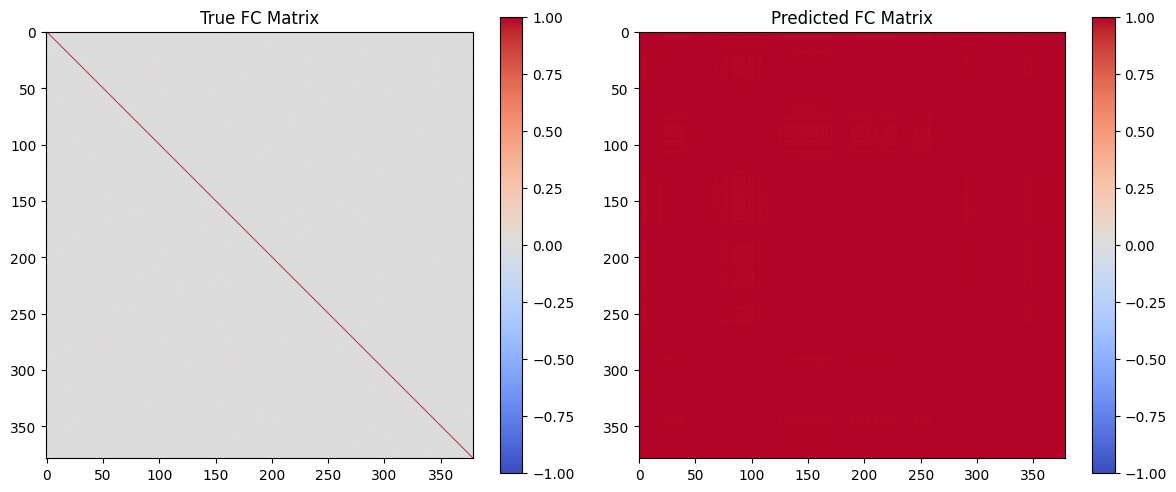

Mean Absolute Difference between FC matrices: 0.9977881392856909
Spatial Pearson correlation between FC matrices: r = 0.0007319103936178213 p-value = 0.8447002769523289


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

def compute_FC(time_series):
    """
    Compute the functional connectivity (FC) matrix using Pearson correlation.
    :param time_series: A numpy array of shape (timepoints, regions)
    :return: FC matrix of shape (regions, regions)
    """
    # Here, each column is a region time series.
    FC = np.corrcoef(time_series, rowvar=False)
    return FC

# Load the true time series from the dummy subject file.
true_file = os.path.join(data_dir, "dummy_subject", "dummy_REST_p.npy")
true_ts = np.load(true_file)
print("True time series shape:", true_ts.shape)

# Load the predicted time series (e.g., from Cell 5).
# predicted_fmri_series_all.npy is expected to have shape (num_subjects, 1200, 379)
predicted_ts_all = np.load("predicted_fmri_series_all.npy")
# For simplicity, we use the first subject's predicted series.
predicted_ts = predicted_ts_all[0]
print("Predicted time series shape:", predicted_ts.shape)

# Compute the FC matrices for true and predicted time series.
FC_true = compute_FC(true_ts)
FC_pred = compute_FC(predicted_ts)

# Plot the FC matrices.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(FC_true, vmin=-1, vmax=1, cmap='coolwarm')
plt.title("True FC Matrix")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(FC_pred, vmin=-1, vmax=1, cmap='coolwarm')
plt.title("Predicted FC Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

# Calculate quantitative metrics between FC matrices.
# We'll use the upper triangle (excluding the diagonal) for comparison.
mask = np.triu(np.ones_like(FC_true, dtype=bool), k=1)

# Mean Absolute Difference between the upper triangles.
diff = np.abs(FC_true[mask] - FC_pred[mask])
mean_abs_diff = np.mean(diff)
print("Mean Absolute Difference between FC matrices:", mean_abs_diff)

# Spatial correlation: Pearson correlation between the flattened upper triangles.
r, p = pearsonr(FC_true[mask].flatten(), FC_pred[mask].flatten())
print("Spatial Pearson correlation between FC matrices: r =", r, "p-value =", p)
